Here the embeddings are extracted from the mdeberta finetuned on the reduced dataset.

In [ ]:
!pip install autogluon
!pip install lightgbm
!pip install pygraphviz

  Using cached pygraphviz-1.13.tar.gz (104 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.13-cp310-cp310-linux_x86_64.whl size=168495 sha256=a4cf37a2a7da99eb75ec267fa2e9a2a3255462a852708619ef6fa6fad5f00c66
  Stored in directory: /root/.cache/pip/wheels/c5/96/10/6c25add1fffc368b1927252bf73b63fcb938de8f4486e23691
Successfully built pygraphviz


In [ ]:
# uninstall autokeras
!pip uninstall autokeras

Found existing installation: autokeras 2.0.0
Uninstalling autokeras-2.0.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/autokeras-2.0.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/autokeras/*
    /usr/local/lib/python3.10/dist-packages/benchmark/*
Proceed (Y/n)? Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 722, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 364, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/re

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
import pandas as pd
from autogluon.tabular import TabularPredictor
from tqdm import tqdm

In [ ]:
# Ensure your model is on the right device (CPU or GPU)
# device = "cuda" if torch.cuda.is_available() else "cpu"
from google.colab import drive
drive.mount('/content/drive')
# Load tokenizer and model
# This should be the path or model identifier you've fine-tuned
model_name = '/content/drive/MyDrive/multitude_split/mdeberta-reduced-2'
tokenizer = AutoTokenizer.from_pretrained('microsoft/mdeberta-v3-base')
model = AutoModel.from_pretrained(model_name)
model.to(device)

model.eval()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/multitude_split/dataset_all.csv')

In [ ]:
import numpy as np
import torch
def extract_embeddings(df, text_column='text', batch_size=32):
    embeddings = []
    dataset = tokenizer(df[text_column].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")
    dataset = torch.utils.data.TensorDataset(dataset['input_ids'], dataset['attention_mask'])
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    with torch.no_grad():
        for input_ids, attention_mask in tqdm(data_loader, desc="Extracting embeddings"):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state
            # Mean pooling
            mean_pooling = torch.mean(hidden_states, dim=1)
            embeddings.append(mean_pooling.cpu().numpy())

    # Concatenate all batch embeddings
    embeddings = np.vstack(embeddings)
    return embeddings


In [ ]:
train = data[data.split == "train"]
test = data[data.split == "test"]

In [ ]:
train_embeddings = extract_embeddings(train, 'text')
test_embeddings = extract_embeddings(test, 'text')

Extracting embeddings: 100%|██████████| 916/916 [22:06<00:00,  1.45s/it]


In [ ]:
print(train_embeddings.shape)
print(test_embeddings.shape)
print(train_embeddings.dtype)
print(test_embeddings.dtype)

(44786, 768)
(29295, 768)
float32
float32


In [ ]:
# save the embeddings
import pickle
with open('/content/drive/MyDrive/multitude_split/train_embeddingsmdeberta-2.pkl', 'wb') as f:
    pickle.dump(train_embeddings, f)
with open('/content/drive/MyDrive/multitude_split/test_embeddingsmdeberta-2.pkl', 'wb') as f:
    pickle.dump(test_embeddings, f)

In [ ]:
# load embeddings
# load the embeddings from saved file
import pickle
with open('/content/drive/MyDrive/multitude_split/train_embeddingsmdeberta-2.pkl', 'rb') as f:
    train_embeddings = pickle.load(f)

with open('/content/drive/MyDrive/multitude_split/test_embeddingsmdeberta-2.pkl', 'rb') as f:
    test_embeddings = pickle.load(f)

In [ ]:
# Convert embeddings into DataFrame
train_embeddings_df = pd.DataFrame(train_embeddings).reset_index(drop=True)
test_embeddings_df = pd.DataFrame(test_embeddings).reset_index(drop=True)

In [ ]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [ ]:
# Add labels to the embeddings DataFrame
train_embeddings_df['label'] = train['label']
test_embeddings_df['label'] = test['label']

In [ ]:
# count the number of values on each label
label_counts = train_embeddings_df['label'].value_counts()
print(label_counts)

label
1    40030
0     4756
Name: count, dtype: int64


In [ ]:
# Save path for the AutoGluon models
save_path = '/content/drive/MyDrive/multitude_split/autogluon_models'

# AutoGluon Tabular Predictor
label_column = 'label'

In [ ]:

predictor = TabularPredictor(label='label', path=save_path, eval_metric='f1_macro',
                             problem_type='binary',  # Adjust according to your specific problem, e.g., 'binary', 'multiclass'
                             verbosity=2)


In [ ]:
train_embeddings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44786 entries, 0 to 44785
Columns: 769 entries, 0 to label
dtypes: float32(768), int64(1)
memory usage: 131.6 MB


Train the Automl predictor on the embeddings.

In [ ]:
predictor.fit(train_data=train_embeddings_df, presets='best_quality', ag_args_fit={'num_gpus': 1})

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
CPU Count:          8
Memory Avail:       46.12 GB / 50.99 GB (90.5%)
Disk Space Avail:   56.29 GB / 100.00 GB (56.3%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stack

In [ ]:
# Evaluate and print the leaderboard
performance = predictor.evaluate(test_embeddings_df, auxiliary_metrics=True)
print("Model performance on test data:", performance)

Model performance on test data: {'accuracy': 0.9560334528076464, 'balanced_accuracy': 0.8850253982939067, 'mcc': 0.7748993802759003, 'roc_auc': 0.9795803176693604, 'f1': 0.9753086419753086, 'precision': 0.9744493392070485, 'recall': 0.9761694616063548}


In [ ]:
# load tabular predictor
predictor = TabularPredictor.load('/content/drive/MyDrive/multitude_split/autogluon_models')

leaderboard = predictor.leaderboard(
    test_embeddings_df,
    silent=True,
    extra_metrics=['accuracy', 'roc_auc', 'f1_macro', 'f1_weighted']
)
leaderboard

,model,score_test,accuracy,roc_auc,f1_macro,f1_weighted,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestGini_BAG_L2,0.959754,0.959754,0.974498,0.895635,0.959366,0.976131,accuracy,128.894280,155.591455,1711.349184,2.008556,15.242831,88.190061,2,True,15
1,RandomForestEntr_BAG_L2,0.959720,0.959720,0.977718,0.895503,0.959323,0.975394,accuracy,128.875114,155.550849,1683.730380,1.989390,15.202226,60.571256,2,True,16
2,LightGBMXT_BAG_L2,0.959584,0.959584,0.980425,0.896554,0.959462,0.976935,accuracy,134.490472,140.870115,1953.204840,7.604748,0.521492,330.045716,2,True,13
3,RandomForestGini_BAG_L1,0.957296,0.957296,0.972316,0.884757,0.955989,0.972402,accuracy,2.339179,15.202035,95.165010,2.339179,15.202035,95.165010,1,True,5
4,CatBoost_BAG_L1,0.956819,0.956819,0.976060,0.884043,0.955611,0.973117,accuracy,5.759835,0.137744,103.428735,5.759835,0.137744,103.428735,1,True,7
5,LightGBMXT_BAG_L1,0.956819,0.956819,0.979361,0.886636,0.956127,0.975550,accuracy,8.882820,0.817950,457.327945,8.882820,0.817950,457.327945,1,True,3
6,RandomForestEntr_BAG_L1,0.956614,0.956614,0.975986,0.883051,0.955312,0.972759,accuracy,2.794387,15.124907,64.676703,2.794387,15.124907,64.676703,1,True,6
7,LightGBM_BAG_L1,0.956341,0.956341,0.978739,0.884828,0.955532,0.975774,accuracy,7.108644,0.758393,611.005941,7.108644,0.758393,611.005941,1,True,4
8,WeightedEnsemble_L2,0.956033,0.956033,0.979580,0.887436,0.955895,0.977806,accuracy,42.234252,32.567504,765.001104,0.842262,0.004073,0.982257,2,True,12
9,ExtraTreesEntr_BAG_L1,0.955556,0.955556,0.975778,0.878907,0.953964,0.971353,accuracy,3.123726,15.433638,7.102408,3.123726,15.433638,7.102408,1,True,9


In [ ]:
best_model = predictor.get_model_best()


<ipython-input-14-a771593e68cf>:1: DeprecationWarning: `get_model_best` has been deprecated and will be removed in version 1.2. Please use `model_best` instead. This will raise an error in the future!
  best_model = predictor.get_model_best()


In [ ]:
print("Best model according to primary metric (default is accuracy):", best_model)


Best model according to primary metric (default is accuracy): WeightedEnsemble_L2


In [ ]:
model_name = leaderboard.iloc[0]['model']
print("Selected model name:", model_name)

Selected model name: RandomForestGini_BAG_L2


In [ ]:
predictions = predictor.predict(test_embeddings_df.drop(columns=['label']), model=model_name)
predictions_prob = predictor.predict_proba(test_embeddings_df.drop(columns=['label']))

In [ ]:
predictions

0        1
1        1
2        1
3        1
4        1
        ..
29290    1
29291    1
29292    0
29293    1
29294    1
Name: label, Length: 29295, dtype: int64

In [ ]:
true_labels = test_embeddings_df['label']
pred_prob = []
for i in range(len(predictions_prob)):
  pred_prob.append(predictions_prob[true_labels[i]][i])

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
true_labels = test_embeddings_df['label']
cr = classification_report(true_labels, predictions, digits=4, zero_division=0)
cm = confusion_matrix(true_labels, predictions)
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
# Fall out or false positive rate
FPR = FP/(FP+TN) if (FP+TN) > 0 else 0
# False negative rate
FNR = FN/(TP+FN) if (TP+FN) > 0 else 0

roc = roc_auc_score(true_labels, predictions)
roc_prob = roc_auc_score(true_labels, pred_prob)

print(cm)
print(cr)
print(f"FPR: {FPR}")
print(f"FNR: {FNR}")
print(f"ROC: {roc}")
print(f"ROC_prob: {roc_prob}")

[[ 2577   659]
 [  520 25539]]
              precision    recall  f1-score   support

           0     0.8321    0.7964    0.8138      3236
           1     0.9748    0.9800    0.9774     26059

    accuracy                         0.9598     29295
   macro avg     0.9035    0.8882    0.8956     29295
weighted avg     0.9591    0.9598    0.9594     29295

FPR: 0.20364647713226205
FNR: 0.019954718139606278
ROC: 0.8881994023640658
ROC_prob: 0.8728298093738128


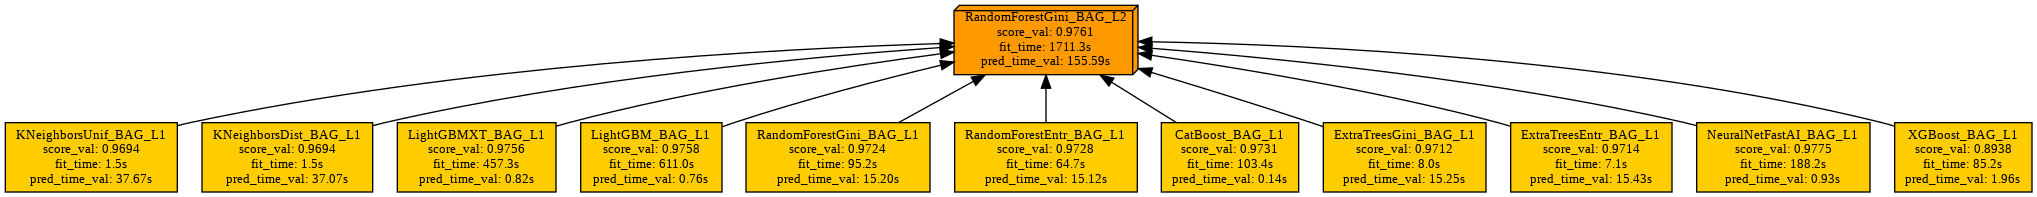

In [ ]:
# plot the predictor
path_to_png = predictor.plot_ensemble_model(model_name)
from IPython.display import Image, display
display(Image(filename=path_to_png))

In [ ]:
from sklearn.metrics import classification_report

# Ground truth labels
true_labels = test_embeddings_df['label']

# Generate the classification report
report = classification_report(true_labels, predictions)  # Replace `your_target_names` with actual class names
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80      3236
           1       0.97      0.98      0.98     26059

    accuracy                           0.96     29295
   macro avg       0.91      0.87      0.89     29295
weighted avg       0.96      0.96      0.96     29295



In [ ]:
# roc auc score
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(true_labels, predictions)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.8746356738922434


In [ ]:
# Get all information available for the predictor
info = predictor.info()

# Retrieve detailed model information
model_details = info['model_info'][model_name]

# Print detailed model info and hyperparameters
print("Model Details:", model_details)
print("Hyperparameters of the model:", model_details['hyperparameters'])

Model Details: {'name': 'RandomForestGini_BAG_L2', 'model_type': 'StackerEnsembleModel', 'problem_type': 'binary', 'eval_metric': 'accuracy', 'stopping_metric': 'accuracy', 'fit_time': 463.8261682987213, 'num_classes': 2, 'quantile_levels': None, 'predict_time': 14.032022714614868, 'val_score': 0.9941276291698299, 'hyperparameters': {'use_orig_features': True, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True, 'use_child_oof': True}, 'hyperparameters_fit': {}, 'hyperparameters_nondefault': ['use_child_oof'], 'ag_args_fit': {'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None, 'drop_unique': False}, 'num_features': 774, 'features': ['387', '548', '262', '342', '348', '5

Using Autokeras for best neural network based on the embeddings

In [ ]:
import autokeras as ak


In [ ]:
X_train = train_embeddings_df.drop(columns=['label'])
y_train = train_embeddings_df['label']
X_test = test_embeddings_df.drop(columns=['label'])
y_test = test_embeddings_df['label']

In [ ]:
import tensorflow as tf
tf.__version__

'2.16.2'

In [ ]:
# convert X_train to nd array
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [ ]:
clf = ak.AutoModel(
    ak.Input(shape=(X_train.shape[1],)),
    outputs=ak.ClassificationHead(num_classes=2),
    overwrite=True,
    max_trials=50
)

clf.fit(X_train, y_train, epochs=30)

Trial 50 Complete [00h 01m 06s]
val_loss: 0.059678759425878525

Best val_loss So Far: 0.05788005515933037
Total elapsed time: 00h 51m 31s
Epoch 1/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9526 - loss: 0.1479
Epoch 2/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9687 - loss: 0.0844
Epoch 3/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9710 - loss: 0.0786
Epoch 4/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9726 - loss: 0.0749
Epoch 5/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9733 - loss: 0.0726
Epoch 6/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9734 - loss: 0.0709
Epoch 7/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9744 - loss: 0.0686
Epoch 8/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9752 - loss: 0.0662
Epoch 9/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9751 - loss: 0.0648
Epoch 10/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9

In [ ]:
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
predictions_prob = clf.predict(X_test)
predictions = (predictions_prob > 0.5).astype(int)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 1 variables whereas the saved optimizer has 13 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


916/916 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
916/916 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
true_labels = y_test
cr = classification_report(true_labels, predictions, digits=4, zero_division=0)
cm = confusion_matrix(true_labels, predictions)
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
# Fall out or false positive rate
FPR = FP/(FP+TN) if (FP+TN) > 0 else 0
# False negative rate
FNR = FN/(TP+FN) if (TP+FN) > 0 else 0

roc = roc_auc_score(true_labels, predictions)
roc_prob = roc_auc_score(true_labels, predictions_prob)

print(cm)
print(cr)
print(f"FPR: {FPR}")
print(f"FNR: {FNR}")
print(f"ROC: {roc}")
print(f"ROC_prob: {roc_prob}")

[[ 2656   580]
 [  787 25272]]
              precision    recall  f1-score   support

           0     0.7714    0.8208    0.7953      3236
           1     0.9776    0.9698    0.9737     26059

    accuracy                         0.9533     29295
   macro avg     0.8745    0.8953    0.8845     29295
weighted avg     0.9548    0.9533    0.9540     29295

FPR: 0.1792336217552534
FNR: 0.030200698415134886
ROC: 0.8952828399148058
ROC_prob: 0.8952828399148058
